# Tutorial 1: 10X Visium data

SEDR can be used to process 10X Visium data to extract low-dimension representation. In this tutorial, we use sample #151673 from Dorsolateral Prefrontal Cortex (DLPFC) dataset to introduce the analysis pipeline. 

The raw Visium data can be downloaded from http://spatial.libd.org/spatialLIBD/.

## Loading packages

In [1]:
import scanpy as sc
import pandas as pd
from sklearn import metrics
import torch

import matplotlib.pyplot as plt
import seaborn as sns

import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

/home/lytq/.conda/envs/SEDR/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/lytq/.conda/envs/SEDR/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/lytq/.conda/envs/SEDR/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/lytq/.conda/envs/SEDR/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/lytq/.conda/envs/SEDR/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is dep

In [2]:
import SEDR

## Setting parameters
random_seed=2023 is used for reproducing the results in manuscript. 

In [3]:
random_seed = 2023
SEDR.fix_seed(random_seed)

In [4]:
# gpu
device = 'cuda:5' if torch.cuda.is_available() else 'cpu'

# path
data_root = Path('../data/DLPFC')

# sample name
sample_name = '151673'
n_clusters = 5 if sample_name in ['151669', '151670', '151671', '151672'] else 7

device

'cuda:5'

In [5]:
# Check if path is correct
if not data_root.exists():
    raise FileNotFoundError('Please check the path!')

print(device)

cuda:5


## Loading data

In [6]:
adata = sc.read_visium(data_root / sample_name)
adata.var_names_make_unique()

df_meta = pd.read_csv(data_root / sample_name / 'metadata.tsv', sep='\t')
adata.obs['layer_guess'] = df_meta['layer_guess']

In [7]:
adata

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'layer_guess'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [8]:
adata.obs

,in_tissue,array_row,array_col,layer_guess
AAACAAGTATCTCCCA-1,1,50,102,Layer3
AAACAATCTACTAGCA-1,1,3,43,Layer1
AAACACCAATAACTGC-1,1,59,19,WM
AAACAGAGCGACTCCT-1,1,14,94,Layer3
AAACAGCTTTCAGAAG-1,1,43,9,Layer5
...,...,...,...,...
TTGTTTCACATCCAGG-1,1,58,42,WM
TTGTTTCATTAGTCTA-1,1,60,30,WM
TTGTTTCCATACAACT-1,1,45,27,Layer6
TTGTTTGTATTACACG-1,1,73,41,WM


In [9]:
adata.var

,gene_ids,feature_types,genome
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38
FAM138A,ENSG00000237613,Gene Expression,GRCh38
OR4F5,ENSG00000186092,Gene Expression,GRCh38
AL627309.1,ENSG00000238009,Gene Expression,GRCh38
AL627309.3,ENSG00000239945,Gene Expression,GRCh38
...,...,...,...
AC233755.2,ENSG00000277856,Gene Expression,GRCh38
AC233755.1,ENSG00000275063,Gene Expression,GRCh38
AC240274.1,ENSG00000271254,Gene Expression,GRCh38
AC213203.1,ENSG00000277475,Gene Expression,GRCh38


In [10]:
adata.uns

OrderedDict([('spatial',
              {'151673': {'images': {'hires': array([[[0.68235296, 0.69803923, 0.69411767],
                         [0.68235296, 0.69411767, 0.6901961 ],
                         [0.6784314 , 0.69803923, 0.6901961 ],
                         ...,
                         [0.6784314 , 0.6901961 , 0.6901961 ],
                         [0.6745098 , 0.69411767, 0.6901961 ],
                         [0.68235296, 0.69803923, 0.6901961 ]],
                 
                        [[0.68235296, 0.69411767, 0.6901961 ],
                         [0.68235296, 0.69803923, 0.6862745 ],
                         [0.68235296, 0.69411767, 0.6862745 ],
                         ...,
                         [0.6745098 , 0.6862745 , 0.6862745 ],
                         [0.6784314 , 0.69411767, 0.6901961 ],
                         [0.68235296, 0.69411767, 0.6901961 ]],
                 
                        [[0.6862745 , 0.69411767, 0.6862745 ],
                         [0.6

In [11]:
adata.obsm

AxisArrays with keys: spatial

In [12]:
adata.layers

Layers with keys: 

### Preprocessing

In [13]:
adata.layers['count'] = adata.X.toarray()
sc.pp.filter_genes(adata, min_cells=50)
sc.pp.filter_genes(adata, min_counts=10)
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer='count', n_top_genes=2000)
adata = adata[:, adata.var['highly_variable'] == True]
sc.pp.scale(adata)

from sklearn.decomposition import PCA  # sklearn PCA is used because PCA in scanpy is not stable. 
adata_X = PCA(n_components=200, random_state=42).fit_transform(adata.X)
adata.obsm['X_pca'] = adata_X

### Constructing neighborhood graph

In [14]:
graph_dict = SEDR.graph_construction(adata, 12)
print(graph_dict)

{'adj_norm': tensor(indices=tensor([[   0,    0,    0,  ..., 3638, 3638, 3638],
                       [   0,  397,  485,  ..., 3402, 3564, 3638]]),
       values=tensor([0.0769, 0.0769, 0.0769,  ..., 0.0769, 0.0769, 0.0769]),
       size=(3639, 3639), nnz=48471, layout=torch.sparse_coo), 'adj_label': tensor(indices=tensor([[   0,    0,    0,  ..., 3638, 3638, 3638],
                       [   0,  397,  485,  ..., 3402, 3564, 3638]]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
       size=(3639, 3639), nnz=48471, dtype=torch.float64,
       layout=torch.sparse_coo), 'norm_value': 0.501836878545686}


### Training SEDR

In [15]:
sedr_net = SEDR.Sedr(adata.obsm['X_pca'], graph_dict, mode='clustering', device=device)
using_dec = True
if using_dec:
    sedr_net.train_with_dec(N=1)
else:
    sedr_net.train_without_dec(N=1)
sedr_feat, _, _, _ = sedr_net.process()
adata.obsm['SEDR'] = sedr_feat

100%|██████████| 200/200 [00:03<00:00, 57.17it/s]


### Clustering

In [16]:
import os

os.environ['R_HOME'] = '/home/lytq/.conda/envs/SEDR/lib/R'
os.environ['R_PATH'] = '/home/lytq/.conda/envs/SEDR/bin/R'
os.environ['R_LIBS_USER'] = '/home/lytq/.conda/envs/SEDR/lib/R/library'
os.environ['PATH'] = '/home/lytq/.conda/envs/SEDR/bin:' + os.environ['PATH']

SEDR.mclust_R(adata, n_clusters, use_rep='SEDR', key_added='SEDR')
print('Finish!')

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
Finish!


### Visualization

#### Spatial domain

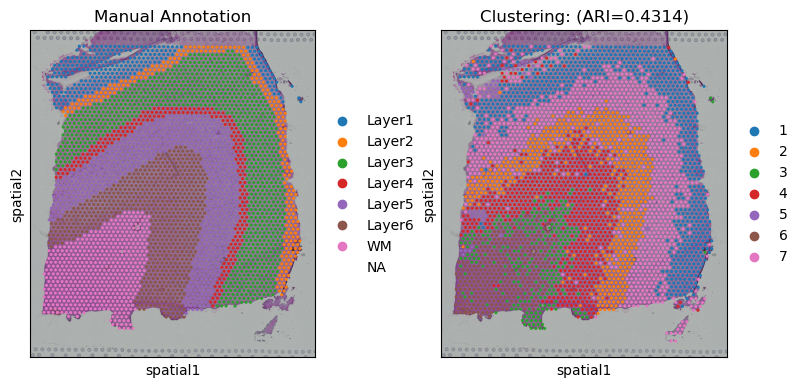

In [17]:
sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
ARI = metrics.adjusted_rand_score(sub_adata.obs['layer_guess'], sub_adata.obs['SEDR'])

fig, axes = plt.subplots(1,2,figsize=(4*2, 4))
sc.pl.spatial(adata, color='layer_guess', ax=axes[0], show=False)
sc.pl.spatial(adata, color='SEDR', ax=axes[1], show=False)
axes[0].set_title('Manual Annotation')
axes[1].set_title('Clustering: (ARI=%.4f)' % ARI)
plt.tight_layout()
plt.show()

#### UMAP

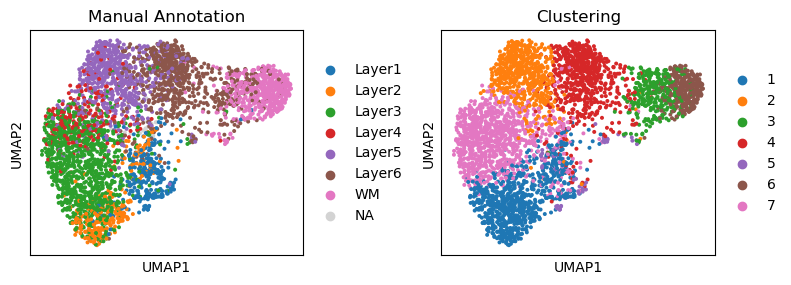

In [18]:
sc.pp.neighbors(adata, use_rep='SEDR', metric='cosine')
sc.tl.umap(adata)

fig, axes = plt.subplots(1,2,figsize=(4*2, 3))
sc.pl.umap(adata, color='layer_guess', ax=axes[0], show=False)
sc.pl.umap(adata, color='SEDR', ax=axes[1], show=False)
axes[0].set_title('Manual Annotation')
axes[1].set_title('Clustering')

for ax in axes:
    ax.set_aspect(1)
    
plt.tight_layout()
plt.show()